In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/ADV_ML_Project'
  os.chdir(CWD)
except:None

Mounted at /content/drive


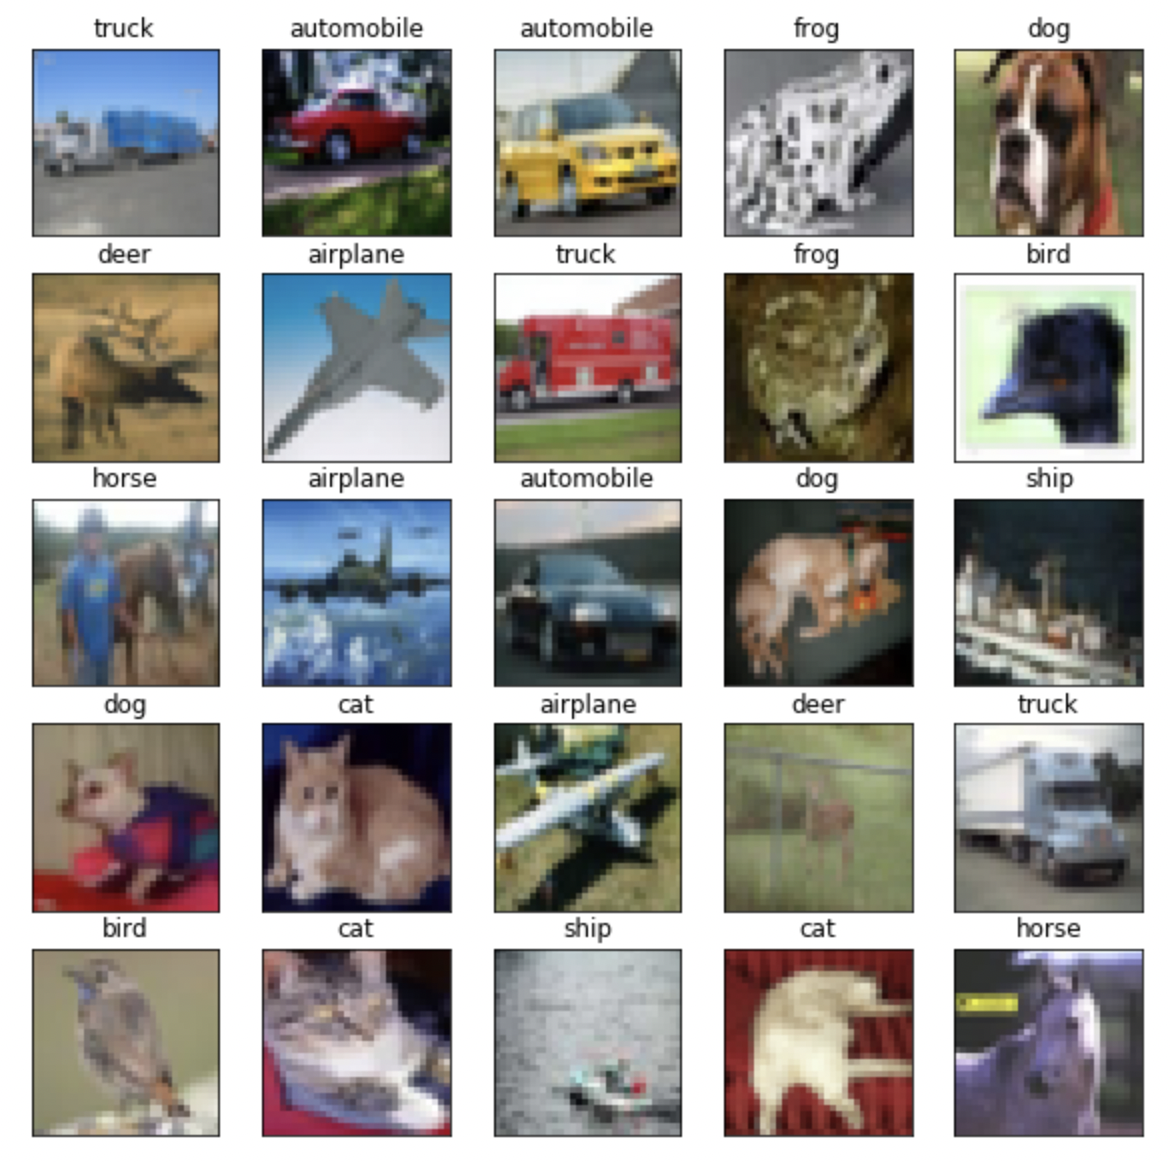

In [2]:
from IPython.display import Image

Image("Cifar10.png")

In [3]:
import argparse
import os
import psutil
import shutil
import subprocess
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import resnet
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else None)
models_path = "./checkpoints-2022-12-15/"

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop(32, 4),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True,
    num_workers=1, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=256, shuffle=False,
    num_workers=10, pin_memory=True)

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=64, shuffle=False,
    num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss().to(device)

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.to(device)
            input_var = input.to(device)
            target_var = target.to(device)

            # if args.half:
            #     input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 100000 == -1:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    # print(' * Prec@1 {top1.avg:.3f}'
    #       .format(top1=top1))

    return top1.avg


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
experiment = {'bn':'Batch-Norm','random':'random (2 P.)','nobn':'no Batch-Norm','full':'All params'}
res_ = ['resnet14', 'resnet32','resnet56', 'resnet110', 'resnet218','resnet434']

import time
t_s = time.time()
for res in res_:
    print(f'#---------------------   Model: {res}   -------------------------#','\n')
    for k in experiment.keys():
        model_type = res + '-' + k 
        net_name = res +'()'
        model_label = res + '-' + experiment[k] 
        # print(net_name,model_type, model_label)
        exec(f'model = resnet.{net_name}')
        model.load_state_dict(torch.load(models_path + model_type + '/model.th')['state_dict'])
        model.eval()
        model.to(device)
       
        val_perc = validate(val_loader, model, criterion)
        print(f'  Learning: {experiment[k]:<20}              Test accuracy: {val_perc}','\n')
    print('\n')
print("run time: ", time.time() - t_s)   

#---------------------   Model: resnet14   -------------------------# 

  Learning: Batch-Norm                        Test accuracy: 48.04 

  Learning: random                            Test accuracy: 66.04 

  Learning: no Batch-Norm                     Test accuracy: 89.24 

  Learning: All params                        Test accuracy: 90.51 



#---------------------   Model: resnet32   -------------------------# 

  Learning: Batch-Norm                        Test accuracy: 57.43 

  Learning: random                            Test accuracy: 75.74 

  Learning: no Batch-Norm                     Test accuracy: 91.24 

  Learning: All params                        Test accuracy: 91.86 



#---------------------   Model: resnet56   -------------------------# 

  Learning: Batch-Norm                        Test accuracy: 62.21 

  Learning: random                            Test accuracy: 77.64 

  Learning: no Batch-Norm                     Test accuracy: 92.01 

  Learning: All param

In [9]:
experiment = {'bn':'Batch-Norm','random':'random (2 P.)','nobn':'no Batch-Norm','full':'All params'}
res_ = ['resnet14', 'resnet32', 'resnet110']

import time
t_s = time.time()
for res in res_:
    print(f'#---------------------   Model: {res}   -------------------------#','\n')
    for k in experiment.keys():
        model_type = res + '-' + k 
        net_name = res +'()'
        model_label = res + '-' + experiment[k] 
        # print(net_name,model_type, model_label)
        exec(f'model = resnet.{net_name}')
        model.load_state_dict(torch.load(models_path + model_type + '/model.th')['state_dict'])
        model.eval()
        model.to(device)
       
        val_perc = validate(val_loader, model, criterion)
        print(f'  Learning: {experiment[k]:<20}              Test accuracy: {val_perc}','\n')
    print('\n')
print("run time: ", time.time() - t_s)       


#---------------------   Model: resnet14   -------------------------# 

  Learning: Batch-Norm                        Test accuracy: 48.04 

  Learning: random (2 P.)                     Test accuracy: 66.04 

  Learning: no Batch-Norm                     Test accuracy: 89.24 

  Learning: All params                        Test accuracy: 90.51 



#---------------------   Model: resnet32   -------------------------# 

  Learning: Batch-Norm                        Test accuracy: 57.43 

  Learning: random (2 P.)                     Test accuracy: 75.74 

  Learning: no Batch-Norm                     Test accuracy: 91.24 

  Learning: All params                        Test accuracy: 91.86 



#---------------------   Model: resnet110   -------------------------# 

  Learning: Batch-Norm                        Test accuracy: 70.27 

  Learning: random (2 P.)                     Test accuracy: 79.78 

  Learning: no Batch-Norm                     Test accuracy: 92.49 

  Learning: All para